In [311]:
#Importing the necessary libraries

import os 
import sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np

import statsmodels.api as sm


In [312]:
#Global Settings 
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [313]:
#Importing Configs
# Define the path where config.py is located
#Mac
os.chdir('/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling')
config_file_path = os.getcwd()
print(config_file_path)

# Add this path to the sys.path
sys.path.append(config_file_path)

import config

#Configs
finbert_models = config.finbert_models
Body = config.Body
database = config.Local_Database

/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling


In [314]:
sentiment = pd.date_range(start='1/1/1990', end='1/1/2024', freq='D')
sentiment = pd.DataFrame(sentiment, columns=['date'])

Body = 'Fed'

state = pd.read_csv(f"{finbert_models}/{Body}/Statements/{Body}_Statements_finbert_model_short.csv")
state = state[['date','sentiment']]
state = state.rename(columns={'sentiment':'statement_sentiment'})
state['date'] = pd.to_datetime(state['date'])
sentiment = pd.merge(sentiment, state, how='left', left_on='date', right_on='date')

minutes = pd.read_csv(f"{finbert_models}/{Body}/Minutes/{Body}_Minutes_finbert_model_short.csv")
minutes = minutes[['date','sentiment']]
minutes = minutes.rename(columns={'sentiment':'minute_sentiment'})
minutes['date'] = pd.to_datetime(minutes['date'])
sentiment = pd.merge(sentiment, minutes, how='left', left_on='date', right_on='date')

# fed_speech = pd.read_csv(f"{finbert_models}/{Body}/Speeches/{Body}_Speeches_finbert_model_short.csv")
# fed_speech = fed_speech[['date','sentiment']]
# fed_speech = fed_speech.rename(columns={'sentiment':'fed_speech_sentiment'})
# fed_speech['date'] = pd.to_datetime(fed_speech['date'])
# sentiment = pd.merge(sentiment, fed_speech, how='left', left_on='date', right_on='date')

Body = 'ECB'
mpd = pd.read_csv(f"{finbert_models}/{Body}/Monetary policy decisions/{Body}_Monetary policy decisions_finbert_model_short.csv")
mpd = mpd[['date','sentiment']]
mpd = mpd.rename(columns={'sentiment':'mpd_sentiment'})

mpd['date'] = pd.to_datetime(mpd['date'])

sentiment = pd.merge(sentiment, mpd, how='left', left_on='date', right_on='date')

pc = pd.read_csv(f"{finbert_models}/{Body}/Press Conferences/{Body}_Press Conferences_finbert_model_short.csv")
pc = pc[['date','sentiment']]
pc = pc.rename(columns={'sentiment':'pc_sentiment'})
pc['date'] = pd.to_datetime(pc['date'])
sentiment = pd.merge(sentiment, pc, how='left', left_on='date', right_on='date')

eb = pd.read_csv(f"{finbert_models}/{Body}/Economic Bulletin/{Body}_Economic Bulletin_finbert_model_short.csv")
eb = eb[['date','sentiment']]
eb = eb.rename(columns={'sentiment':'eb_sentiment'})
eb['date'] = pd.to_datetime(eb['date'])
sentiment = pd.merge(sentiment, eb, how='left', left_on='date', right_on='date')

# ecb_speech = pd.read_csv(f"{finbert_models}/{Body}/Speeches/{Body}_Speeches_finbert_model_short.csv")
# ecb_speech = ecb_speech[['date','sentiment']]
# ecb_speech = ecb_speech.rename(columns={'sentiment':'ecb_speech_sentiment'})
# ecb_speech['date'] = pd.to_datetime(ecb_speech['date'])
# sentiment = pd.merge(sentiment, ecb_speech, how='left', left_on='date', right_on='date')

sentiment = sentiment[(sentiment['date'] >= '2000-01-01') & (sentiment['date'] <= '2023-06-30')]


In [315]:
sentiment = sentiment.groupby(pd.Grouper(key='date', freq='D')).mean().reset_index()

In [316]:
sent_temp = sentiment.copy(deep=True)
#Forward fill all na values for sentiment

sent_temp['statement_sentiment'] = sent_temp['statement_sentiment'].fillna(method='ffill')

sent_temp['diff_fed_sentiment'] = sent_temp['minute_sentiment'] - sent_temp['statement_sentiment']

#drop all rows where minute_sentiment is na
sent_temp = sent_temp.dropna(subset=['minute_sentiment'])

sent_temp = sent_temp[['date', 'diff_fed_sentiment']]

sentiment = pd.merge(sentiment, sent_temp, how='left', left_on='date', right_on='date')

In [317]:
#group pc_sentiment, mpd_sentiment, and eb_sentiment into one variable called euro_sentiment that is the average of the three and ignores nan values
sentiment['euro_sentiment'] = sentiment[['pc_sentiment', 'mpd_sentiment']].mean(axis=1)


In [318]:
mich = pd.read_csv(f'{database}/Market Data/Michigan/michigan_sent.csv')
#convert Month from a string to a number
mich['Month'] = mich['Month'].str.replace('January', '01')
mich['Month'] = mich['Month'].str.replace('February', '02')
mich['Month'] = mich['Month'].str.replace('March', '03')
mich['Month'] = mich['Month'].str.replace('April', '04')
mich['Month'] = mich['Month'].str.replace('May', '05')
mich['Month'] = mich['Month'].str.replace('June', '06')
mich['Month'] = mich['Month'].str.replace('July', '07')
mich['Month'] = mich['Month'].str.replace('August', '08')
mich['Month'] = mich['Month'].str.replace('September', '09')
mich['Month'] = mich['Month'].str.replace('October', '10')
mich['Month'] = mich['Month'].str.replace('November', '11')
mich['Month'] = mich['Month'].str.replace('December', '12')
    
#combine Month and YYYY columns and convert to datetime
mich['date'] = mich['Month'].astype(str) + '-' + mich['YYYY'].astype(str)
mich['date'] = pd.to_datetime(mich['date'])
mich = mich[['date', 'ICS_ALL']]
mich = mich.rename(columns={'ICS_ALL':'michigan_sentiment'})

sentiment = pd.merge(sentiment, mich, how='outer', left_on='date', right_on='date')

/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_7242/3042254654.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  mich['date'] = pd.to_datetime(mich['date'])


In [319]:
market =pd.read_csv(f'{database}/Market Data/All Market Data.csv')
market = market.rename(columns={'PCE':'pce', 'GDP':'gdp', 'GDPPOT':'gdp_pot'})
market['date'] = pd.to_datetime(market['date'])


In [320]:
taylor = pd.read_csv(f'/Users/kylenabors/Documents/Database/Market Data/Taylor/Taylor.csv')
taylor['date'] = pd.to_datetime(taylor['date'])
taylor = taylor.rename(columns={'Taylor':'taylor_fred'})

In [321]:
sentiment = pd.merge(sentiment, market, how='left', left_on='date', right_on='date')
sentiment = pd.merge(sentiment, taylor, how='left', left_on='date', right_on='date')

In [322]:
sentiment = sentiment[(sentiment['date'] >= '2000-01-01') & (sentiment['date'] <= '2023-06-30')]
sentiment = sentiment.set_index('date')
sentiment = sentiment.resample('Q').mean().reset_index()

# sentiment = sentiment.drop(columns=['sp500_return', 'sp500_return_volume'])

# spreturn = pd.read_csv(f'{database}/Market Data/SP500/SP500 Returns Quarterly.csv')
# spreturn = spreturn.rename(columns={'Date':'date', 'PX_LAST':'sp500_return', 'PX_VOLUME':'sp500_return_volume'})
# #remove dates from date row that are "#NAME?"
# spreturn = spreturn[spreturn['date'] != '#NAME?']
# print(spreturn.head()) 
# spreturn['date'] = pd.to_datetime(spreturn['date'])
# sentiment = pd.merge(sentiment, spreturn, how='left', left_on='date', right_on='date')

In [323]:
#create a list of all the columns in the dataframe sentiment
columns = sentiment.columns
#Remove data column
columns = columns[1:]

#loop through the columns and normalize the data
for column in columns:
    sentiment[column] = (sentiment[column] - sentiment[column].mean()) / (sentiment[column].max() - sentiment[column].min())

In [324]:
filter_items = ['minute_sentiment', 'mpd_sentiment']

for item in filter_items:
    filter_df = sentiment.copy(deep=True)
    filter_df = filter_df[['date', f'{item}']]

    cycle, trend = sm.tsa.filters.hpfilter(filter_df[f'{item}'], 1600)

    item_decomp = filter_df[[f'{item}']]
    item_decomp[f"{item}_cycle"] = cycle
    item_decomp[f"{item}_trend"] = trend

    filter_df = pd.merge(filter_df, item_decomp, on=f'{item}', how='left')  
    filter_df = filter_df[['date', f'{item}_cycle', f'{item}_trend']]
    sentiment = pd.merge(sentiment, filter_df, on='date', how='left')

In [325]:
sentiment['gap'] = (sentiment['gdp'] - sentiment['gdp_pot'])/sentiment['gdp_pot']
sentiment['gap'] = sentiment['gap']*100

In [326]:
sentiment['taylor'] = 2 + sentiment['gdpdef'] + 0.5*(sentiment['gdpdef'] - 2) + 0.5*(sentiment['gap'])


#NORMALIZE TAYLOR DATA
sentiment['taylor'] = (sentiment['taylor'] - sentiment['taylor'].mean()) / (sentiment['taylor'].max() - sentiment['taylor'].min())

In [327]:
#if statment_sentiment is greater than 0 make 1 if it is less than 0 make -1
#sentiment['statement_sentiment'] = np.where(sentiment['statement_sentiment'] > 0, 1, -1)

In [328]:
sentiment_groups = ['statement_sentiment', 'minute_sentiment', 'minute_sentiment_trend', 'minute_sentiment_cycle', 'mpd_sentiment', 'michigan_sentiment', 'diff_fed_sentiment', 'mpd_sentiment_trend', 'mpd_sentiment_cycle']
for group in sentiment_groups:
    for i in range(0, 6):
        sentiment[f'{group}_{i}'] = sentiment[f'{group}'].shift(i)
        sentiment[f'{group}_{i}'] =  sentiment[f'{group}_{i}'].diff()
        #sentiment[f'{group}_sentiment_forward_{i}'] = sentiment[f'{group}_sentiment'].shift(-i)
        
market_groups = ['fedfunds', 'taylor', 'sp500_return', 'taylor_euro']

for group in market_groups:
    for i in range(0, 5):
        sentiment[f'{group}_{i}'] = sentiment[f'{group}'].shift(i)
        #sentiment[f'{group}_forward_{i}'] = sentiment[f'{group}'].shift(-i)

/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_7242/1122377633.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sentiment[f'{group}_{i}'] = sentiment[f'{group}'].shift(i)
/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_7242/1122377633.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sentiment[f'{group}_{i}'] = sentiment[f'{group}'].shift(i)
/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_7242/1122377633.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

In [329]:
sentiment.to_csv(f'/Users/kylenabors/Documents/Database/Models/FinBERT Models/taylor.csv', index=False)


Index(['date', 'statement_sentiment', 'minute_sentiment', 'mpd_sentiment',
       'pc_sentiment', 'eb_sentiment', 'diff_fed_sentiment', 'euro_sentiment',
       'michigan_sentiment', 'sp500_price',
       ...
       'sp500_return_0', 'sp500_return_1', 'sp500_return_2', 'sp500_return_3',
       'sp500_return_4', 'taylor_euro_0', 'taylor_euro_1', 'taylor_euro_2',
       'taylor_euro_3', 'taylor_euro_4'],
      dtype='object', length=107)


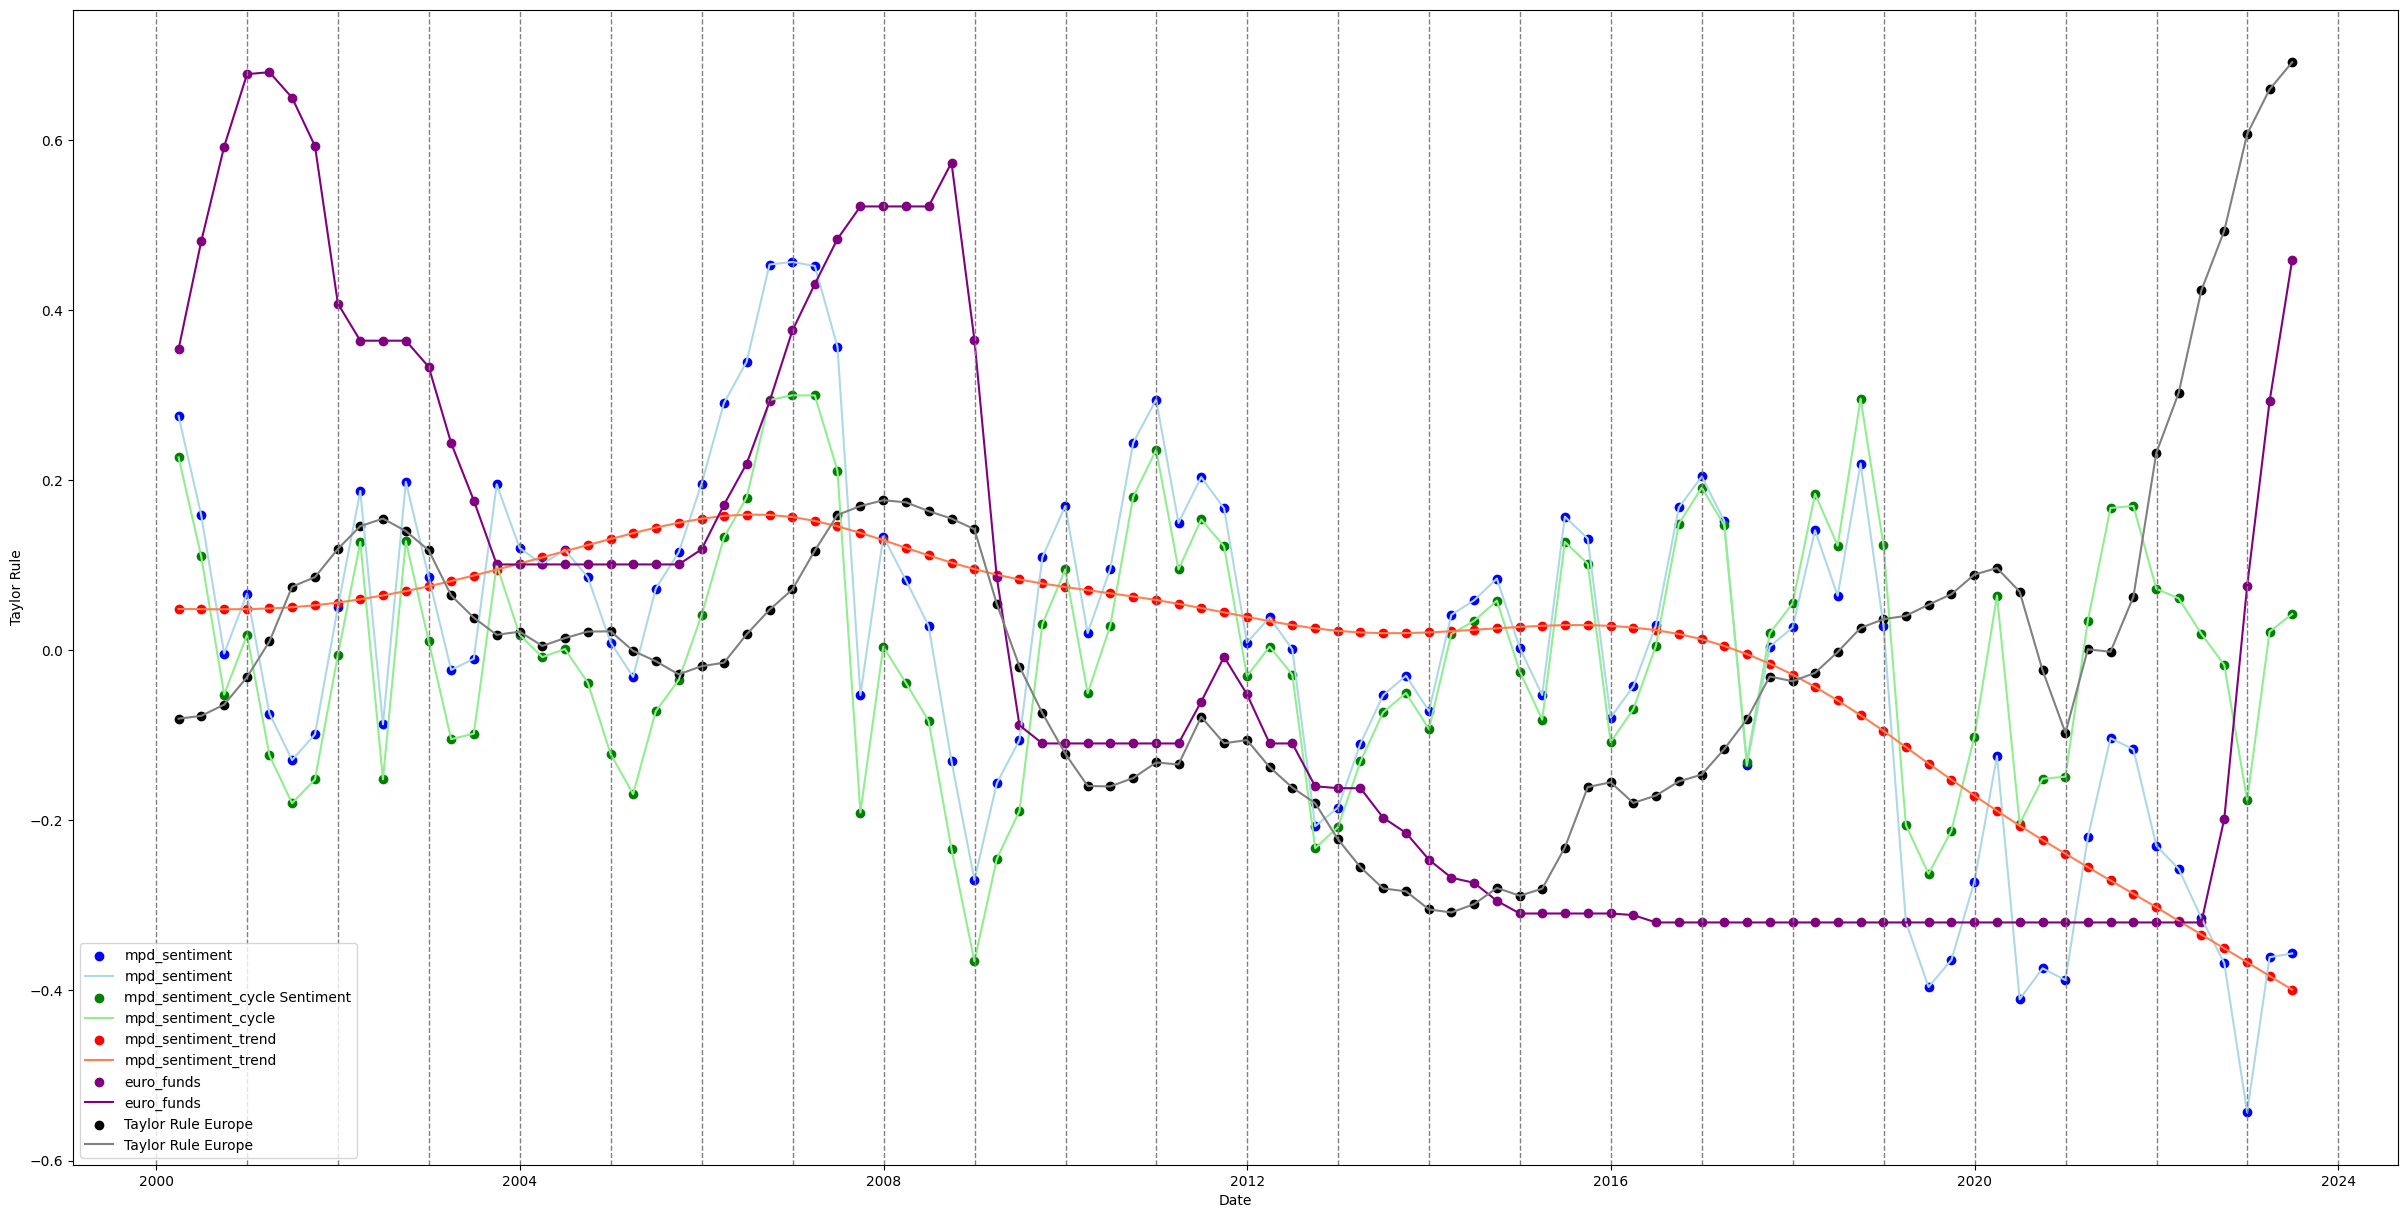

In [330]:
print(sentiment.columns)

x1 = 'mpd_sentiment'
x2 = 'mpd_sentiment_cycle'
x3 = 'mpd_sentiment_trend'
x4 = 'euro_funds'

#Graph the Data
fig, ax = plt.subplots(figsize = (30, 15))

ax.scatter(sentiment['date'], sentiment[f'{x1}'], label=f'{x1}', color='blue')
ax.plot(sentiment['date'], sentiment[f'{x1}'], label=f'{x1}', color='lightblue')

ax.scatter(sentiment['date'], sentiment[f'{x2}'], label=f'{x2} Sentiment', color='green')
ax.plot(sentiment['date'], sentiment[f'{x2}'], label=f'{x2}', color='lightgreen')

ax.scatter(sentiment['date'], sentiment[f'{x3}'], label=f'{x3}', color='red')
ax.plot(sentiment['date'], sentiment[f'{x3}'], label=f'{x3}', color='coral')

ax.scatter(sentiment['date'], sentiment[f'{x4}'], label=f'{x4}', color='purple')
ax.plot(sentiment['date'], sentiment[f'{x4}'], label=f'{x4}', color='purple')

# ax.scatter(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='black')
# ax.plot(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='grey')

ax.scatter(sentiment['date'], sentiment['taylor_euro'], label='Taylor Rule Europe', color='black')
ax.plot(sentiment['date'], sentiment['taylor_euro'], label='Taylor Rule Europe', color='grey')

#Create a vertical line at every year 
for year in range(2000, 2025):
    ax.axvline(pd.to_datetime(f'{year}-01-01'), color='gray', linestyle='--', lw=1)

ax.set_xlabel('Date')
ax.set_ylabel('Taylor Rule')
ax.legend()
plt.show()


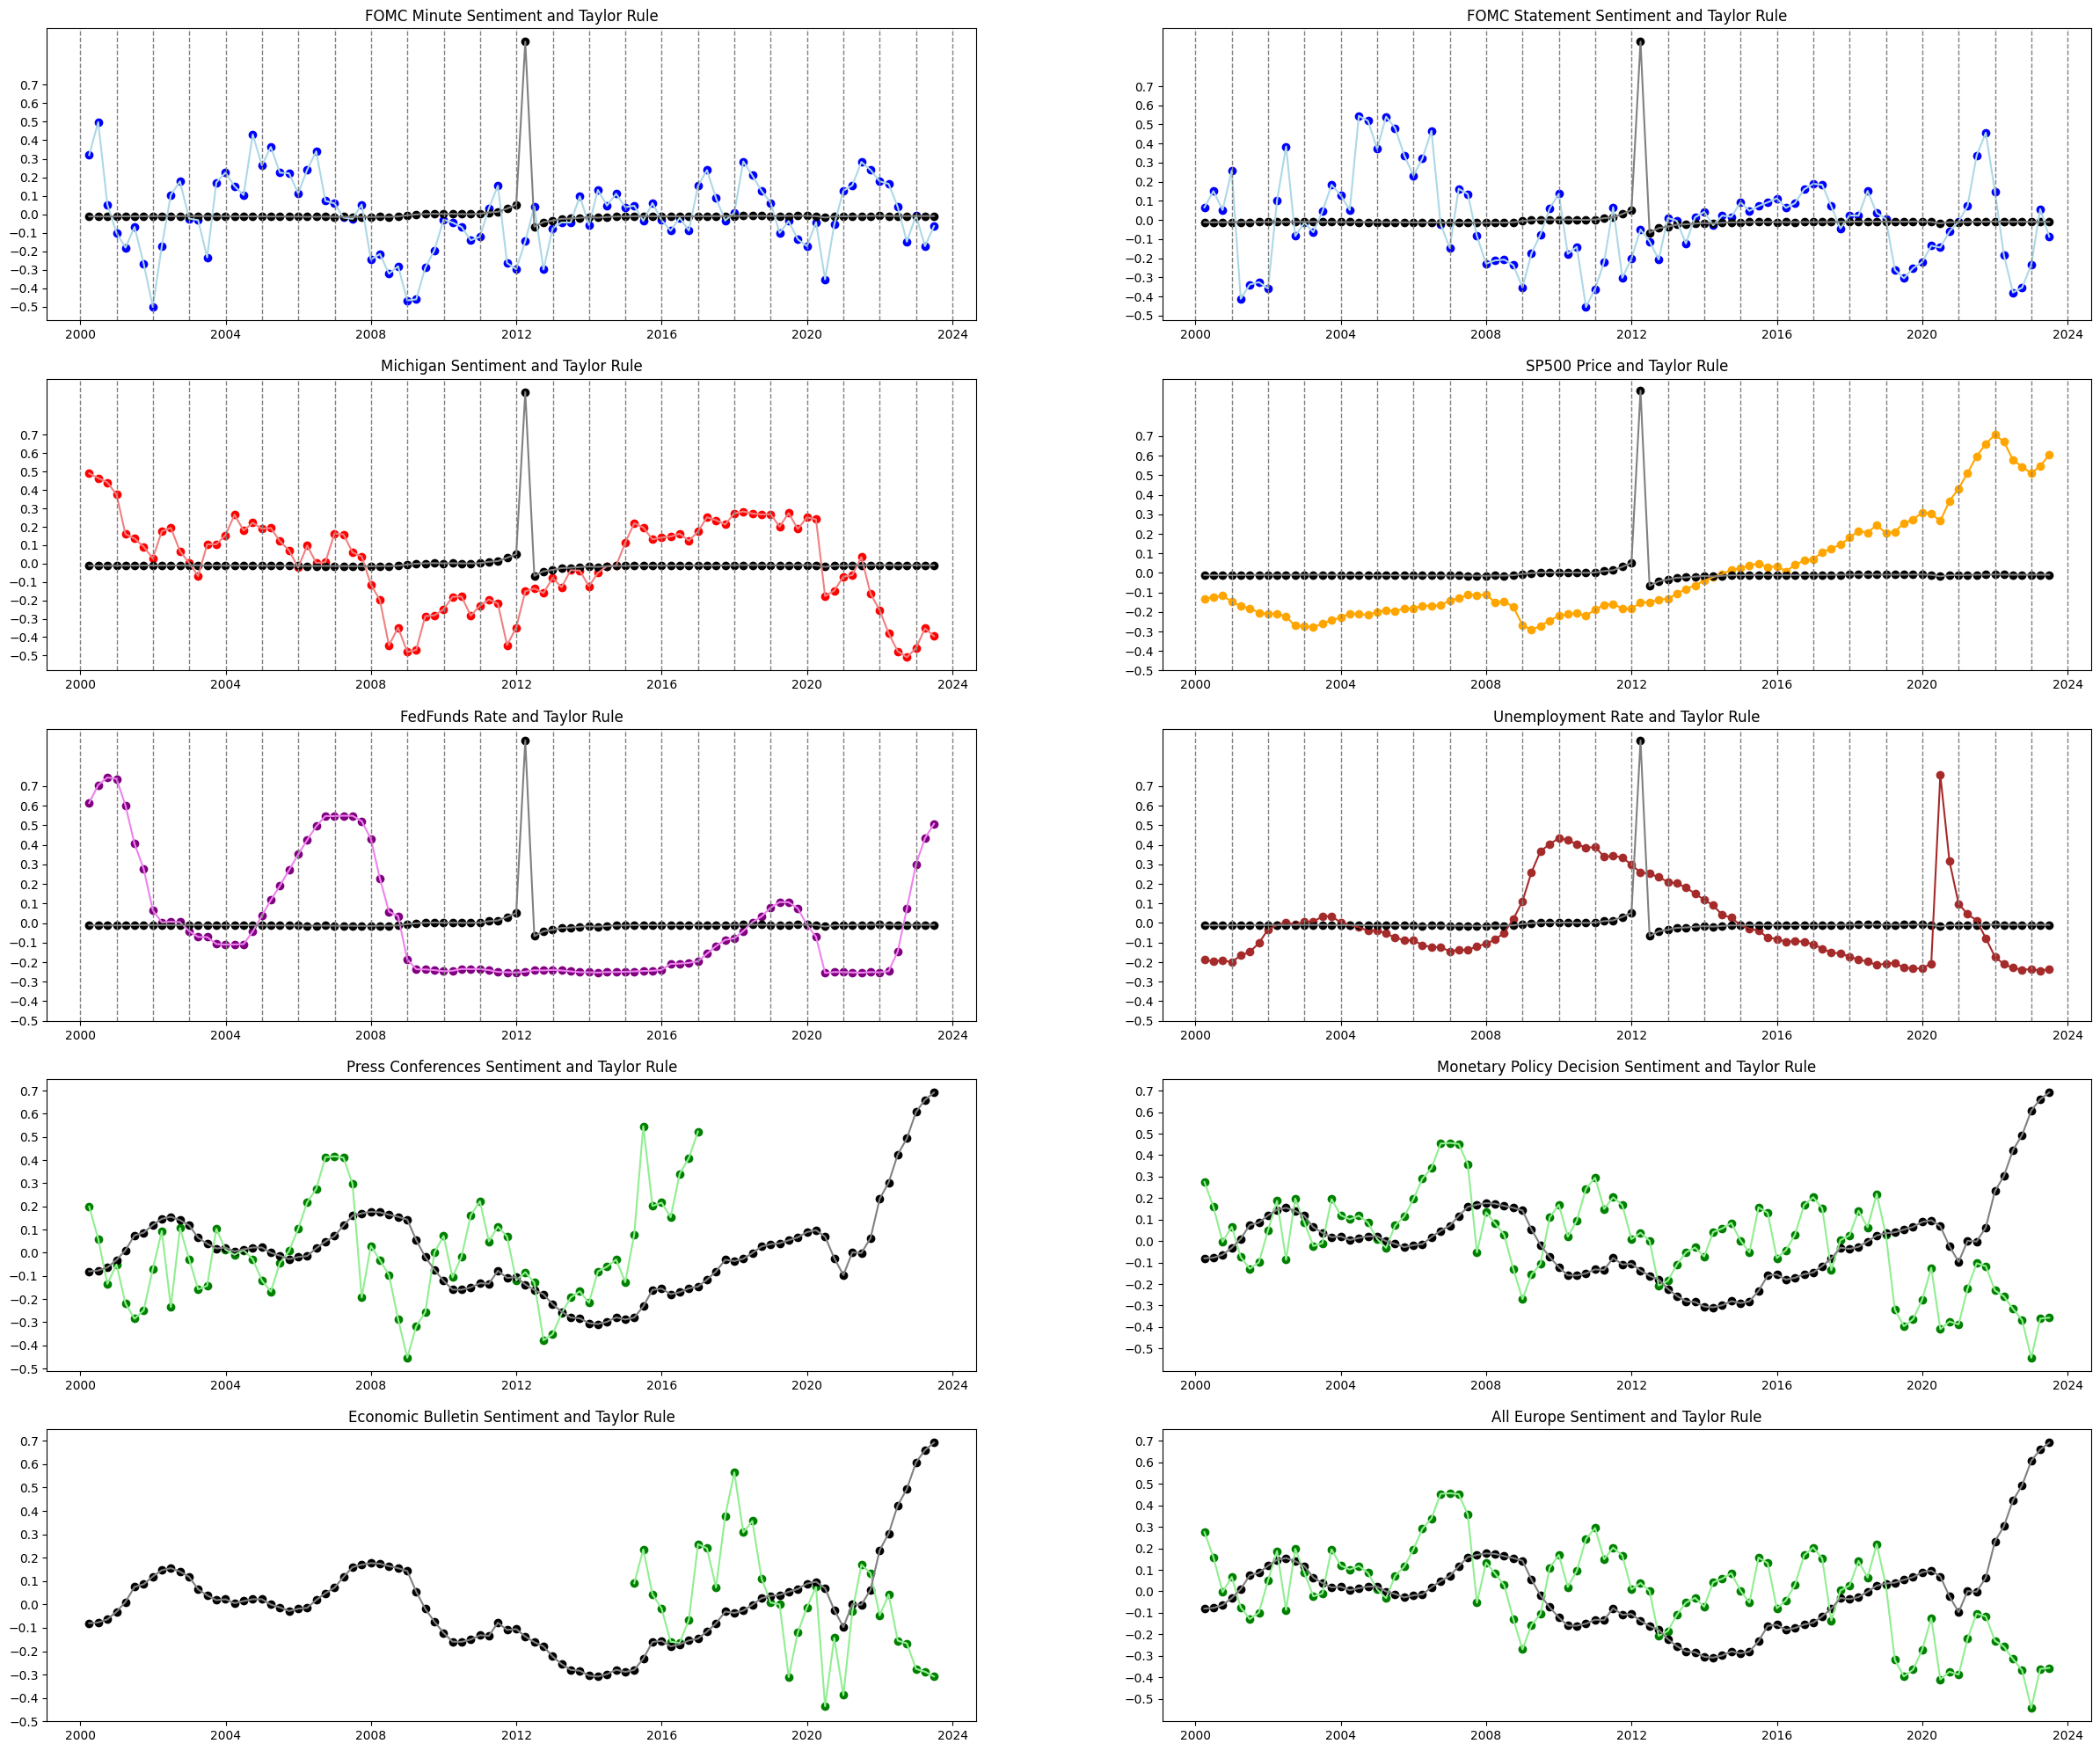

In [331]:
#recreate the previous graph but using multiple subplots where every subplot is a different variable compared to the Taylor Rule
fig, ax = plt.subplots(5, 2, figsize = (30, 25))

ax[0, 0].scatter(sentiment['date'], sentiment['minute_sentiment'], label='FOMC Minute Sentiment', color='blue')
ax[0, 0].plot(sentiment['date'], sentiment['minute_sentiment'], label='FOMC Minute Sentiment', color='lightblue')
ax[0, 0].scatter(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='black')
ax[0, 0].plot(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='grey')
ax[0, 0].set_title('FOMC Minute Sentiment and Taylor Rule')
ax[0, 0].set_yticks(np.arange(-0.5, 0.8, 0.1))

ax[0, 1].scatter(sentiment['date'], sentiment['statement_sentiment'], label='Statement Sentiment', color='blue')
ax[0, 1].plot(sentiment['date'], sentiment['statement_sentiment'], label='Statement Sentiment', color='lightblue')
ax[0, 1].scatter(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='black')
ax[0, 1].plot(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='grey')
ax[0, 1].set_title('FOMC Statement Sentiment and Taylor Rule')
ax[0, 1].set_yticks(np.arange(-0.5, 0.8, 0.1))

ax[1, 0].scatter(sentiment['date'], sentiment['michigan_sentiment'], label='Michigan Sentiment', color='red')
ax[1, 0].plot(sentiment['date'], sentiment['michigan_sentiment'], label='Michigan Sentiment', color='lightcoral')
ax[1, 0].scatter(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='black')
ax[1, 0].plot(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='grey')
ax[1, 0].set_title('Michigan Sentiment and Taylor Rule')
ax[1, 0].set_yticks(np.arange(-0.5, 0.8, 0.1))

ax[1, 1].scatter(sentiment['date'], sentiment['sp500_price'], label='SP500 Price', color='orange')
ax[1, 1].plot(sentiment['date'], sentiment['sp500_price'], label='SP500 Price', color='orange')
ax[1, 1].scatter(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='black')
ax[1, 1].plot(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='grey')
ax[1, 1].set_title('SP500 Price and Taylor Rule')
ax[1, 1].set_yticks(np.arange(-0.5, 0.8, 0.1))

ax[2, 0].scatter(sentiment['date'], sentiment['fedfunds'], label='FedFunds Rate', color='purple')
ax[2, 0].plot(sentiment['date'], sentiment['fedfunds'], label='FedFunds Rate', color='violet')
ax[2, 0].scatter(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='black')
ax[2, 0].plot(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='grey')
ax[2, 0].set_title('FedFunds Rate and Taylor Rule')
ax[2, 0].set_yticks(np.arange(-0.5, 0.8, 0.1))

ax[2, 1].scatter(sentiment['date'], sentiment['unemployment'], label='Unemployment Rate', color='brown')
ax[2, 1].plot(sentiment['date'], sentiment['unemployment'], label='Unemployment Rate', color='brown')
ax[2, 1].scatter(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='black')
ax[2, 1].plot(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='grey')
ax[2, 1].set_title('Unemployment Rate and Taylor Rule')
ax[2, 1].set_yticks(np.arange(-0.5, 0.8, 0.1))

ax[3, 0].scatter(sentiment['date'], sentiment['pc_sentiment'], label='Press Conferences Sentiment', color='green')
ax[3, 0].plot(sentiment['date'], sentiment['pc_sentiment'], label='Press Conferences Sentiment', color='lightgreen')
ax[3, 0].scatter(sentiment['date'], sentiment['taylor_euro'], label='Taylor Rule Europe', color='black')
ax[3, 0].plot(sentiment['date'], sentiment['taylor_euro'], label='Taylor Rule Europe', color='grey')
ax[3, 0].set_title('Press Conferences Sentiment and Taylor Rule')
ax[3, 0].set_yticks(np.arange(-0.5, 0.8, 0.1))

ax[3, 1].scatter(sentiment['date'], sentiment['mpd_sentiment'], label='Monetary Policy Decision Sentiment', color='green')
ax[3, 1].plot(sentiment['date'], sentiment['mpd_sentiment'], label='Monetary Policy Decision Sentiment', color='lightgreen')
ax[3, 1].scatter(sentiment['date'], sentiment['taylor_euro'], label='Taylor Rule Europe', color='black')
ax[3, 1].plot(sentiment['date'], sentiment['taylor_euro'], label='Taylor Rule Europe', color='grey')
ax[3, 1].set_title('Monetary Policy Decision Sentiment and Taylor Rule')
ax[3, 1].set_yticks(np.arange(-0.5, 0.8, 0.1))

ax[4, 0].scatter(sentiment['date'], sentiment['eb_sentiment'], label='Economic Bulletin Sentiment', color='green')
ax[4, 0].plot(sentiment['date'], sentiment['eb_sentiment'], label='Economic Bulletin Sentiment', color='lightgreen')
ax[4, 0].scatter(sentiment['date'], sentiment['taylor_euro'], label='Taylor Rule', color='black')
ax[4, 0].plot(sentiment['date'], sentiment['taylor_euro'], label='Taylor Rule', color='grey')
ax[4, 0].set_title('Economic Bulletin Sentiment and Taylor Rule')
ax[4, 0].set_yticks(np.arange(-0.5, 0.8, 0.1))

ax[4, 1].scatter(sentiment['date'], sentiment['euro_sentiment'], label='Europe Sentiment', color='green')
ax[4, 1].plot(sentiment['date'], sentiment['euro_sentiment'], label='Europe Sentiment', color='lightgreen')
ax[4, 1].scatter(sentiment['date'], sentiment['taylor_euro'], label='Taylor Rule Europe', color='black')
ax[4, 1].plot(sentiment['date'], sentiment['taylor_euro'], label='Taylor Rule Europe', color='grey')
ax[4, 1].set_title('All Europe Sentiment and Taylor Rule')
ax[4, 1].set_yticks(np.arange(-0.5, 0.8, 0.1))


#Create a vertical line at every year
for i in range(3):
    for j in range(2):
        for year in range(2000, 2025):
            ax[i, j].axvline(pd.to_datetime(f'{year}-01-01'), color='gray', linestyle='--', lw=1)
            
plt.show()